<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## Second Level Analysis - **Rat** Hemodynamic Response Function

The present jupyter notebook contains the code to reproduce the second level analysis. Select the hemodynamic response functions used during the first level analysis: rat_hrf_gamma_diff or rat_hrf_delay_disp. It enables to fetch the files in the corresponding directories. 

Follow the code step-wise. 

In [5]:
# --- Imports ---
import os
import glob
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib

from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

**Select the hemodynamic response function!** 

To input the corresponding data.

In [6]:
# --- Select the HRF ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    rat_hrf_delay_disp
    rat_hrf_gamma_diff
"""
hrf_function = 'rat_hrf_gamma_diff'
#hrf_function = 'rat_hrf_delay_disp'

**Define input and output directories.**

In [7]:
# --- Init variables --- 
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder="/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/"

# --- Data path --- 
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')] 

# --- Output directories ---
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/'
subdirectories = ['rat_hrf_gamma_diff', 'rat_hrf_delay_disp']

base_dir = os.path.join(output_dir, 'rat_hrf_gamma_diff') if hrf_function == 'rat_hrf_gamma_diff' else os.path.join(output_dir, 'rat_hrf_delay_disp')
image_dir = os.path.join(base_dir, 'image/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
z_score_dir = os.path.join(base_dir, 'z_score/')
p_value_dir = os.path.join(base_dir, 'p_value/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['image', 'beta_estimates', 'z_score', 'p_value']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

### Let's analyse!

1. Load the dataset based on its ID and the HRF function used during first analysis.
2. Compute the design matrix and the first level model
3. Compute the contrast and plot the statistical maps
7. Save ouputs in specific directories

First level analysis used: rat_hrf_gamma_diff
ID: 02001
number of subjects: 10
ID: 02002
number of subjects: 9
ID: 02003
number of subjects: 9
ID: 02004
number of subjects: 10
ID: 02005
number of subjects: 10
ID: 02006
number of subjects: 10
ID: 02007
number of subjects: 8
ID: 02008
number of subjects: 9
ID: 02009
number of subjects: 10
ID: 02010
number of subjects: 10
ID: 02011
number of subjects: 10
ID: 02012
number of subjects: 9
ID: 02013
number of subjects: 10
ID: 02014
number of subjects: 9
ID: 02015
number of subjects: 10
ID: 02016
number of subjects: 10
ID: 02017
number of subjects: 10
ID: 02018
number of subjects: 9
ID: 02019
number of subjects: 8


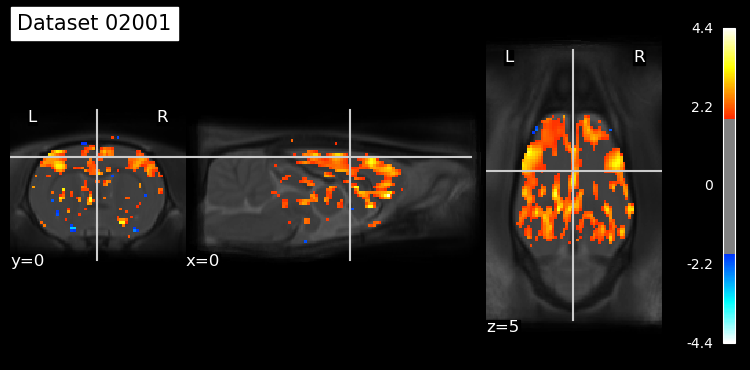

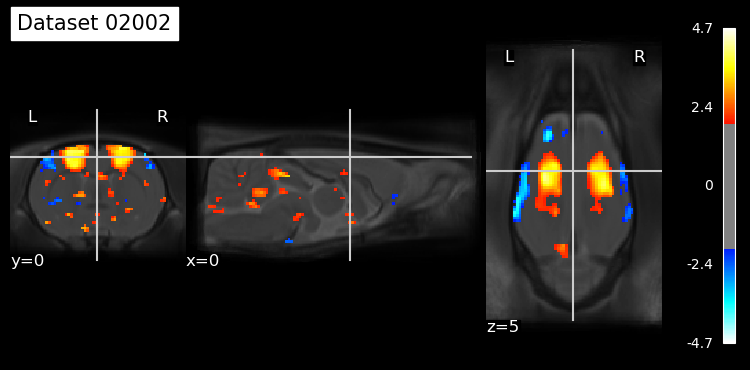

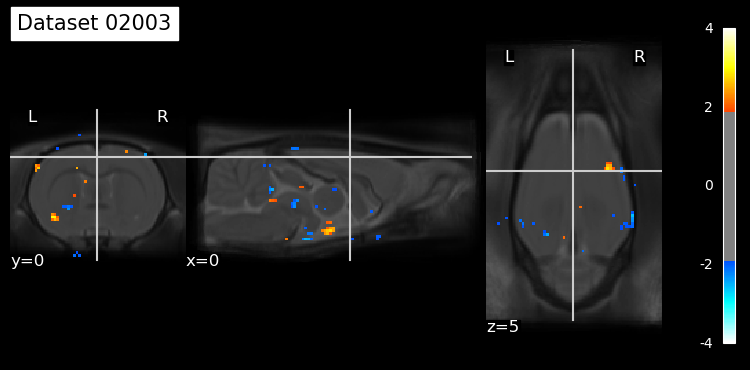

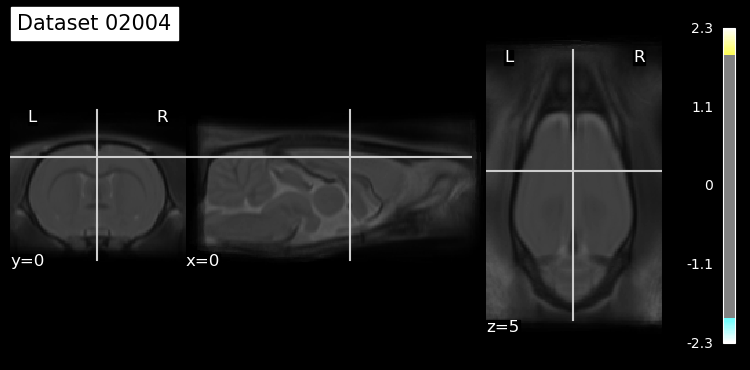

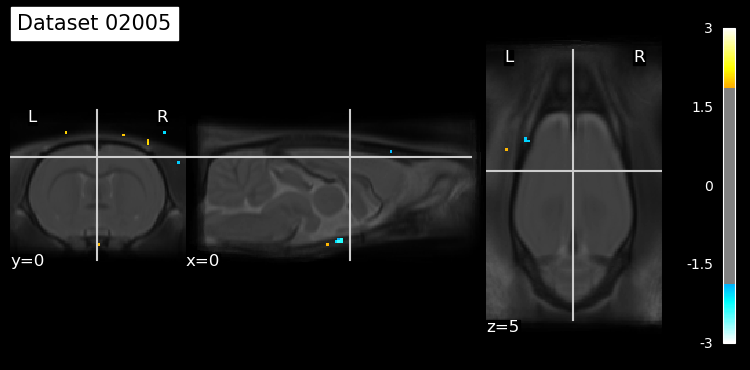

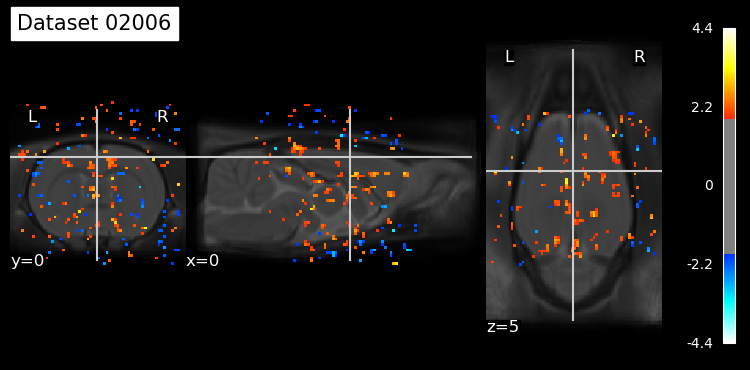

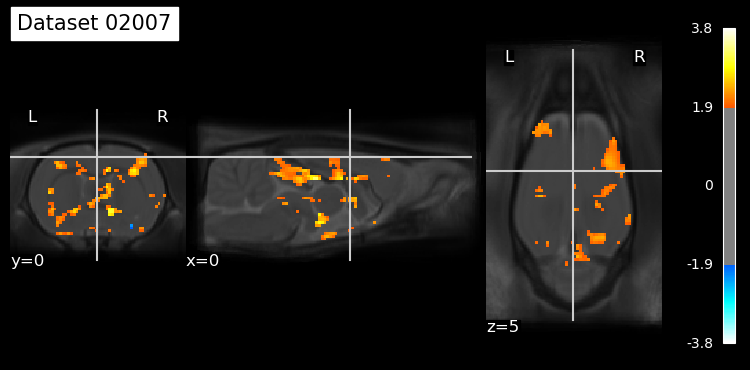

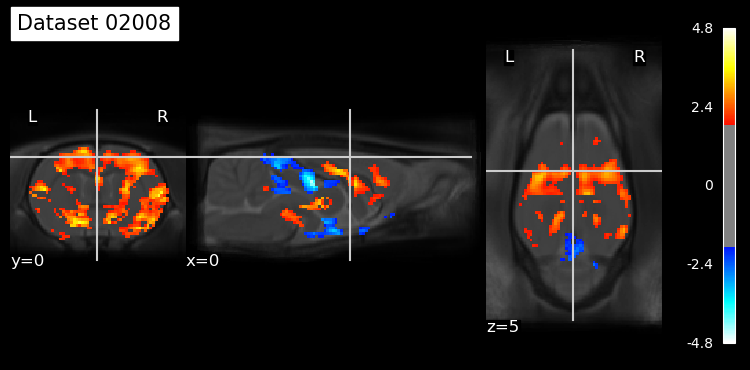

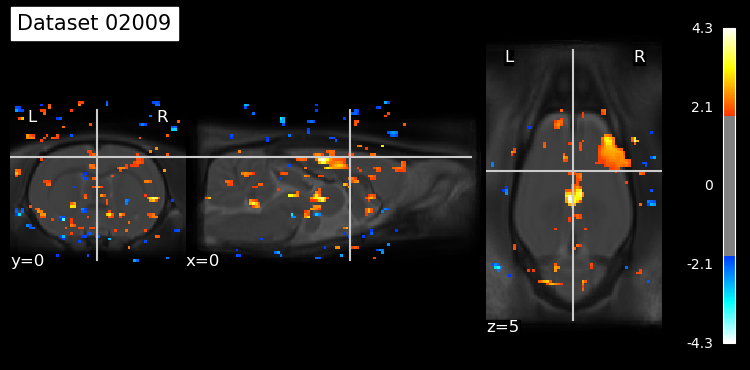

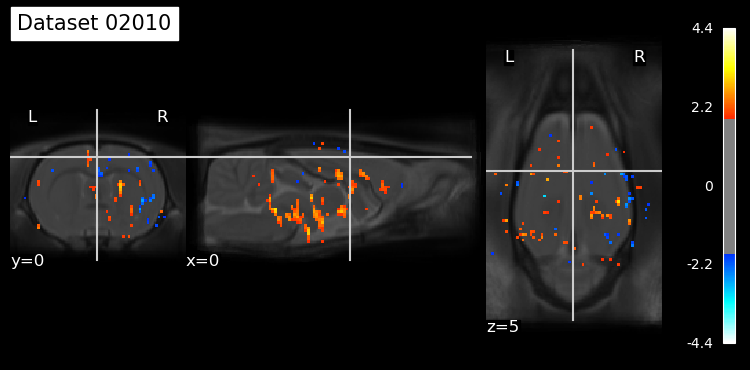

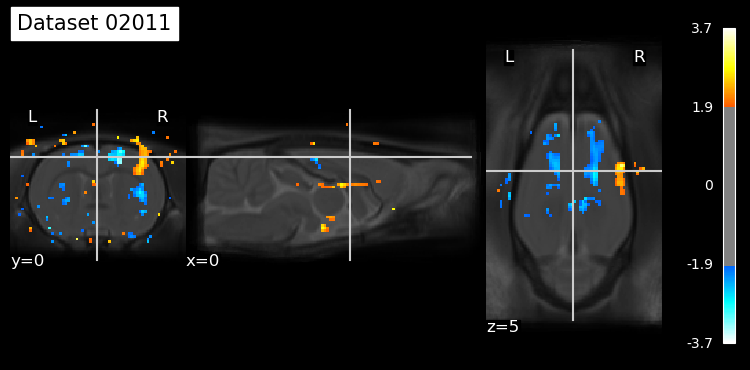

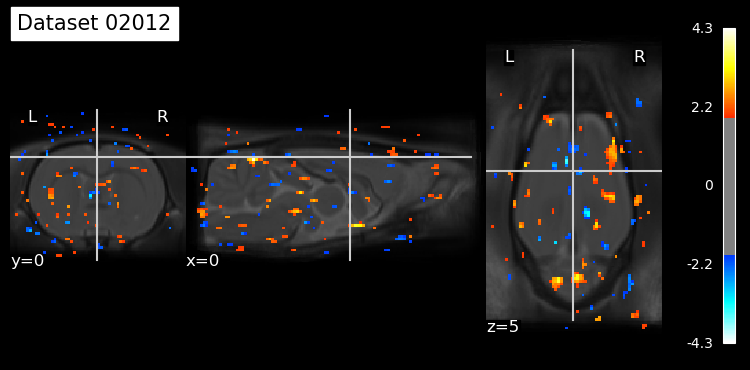

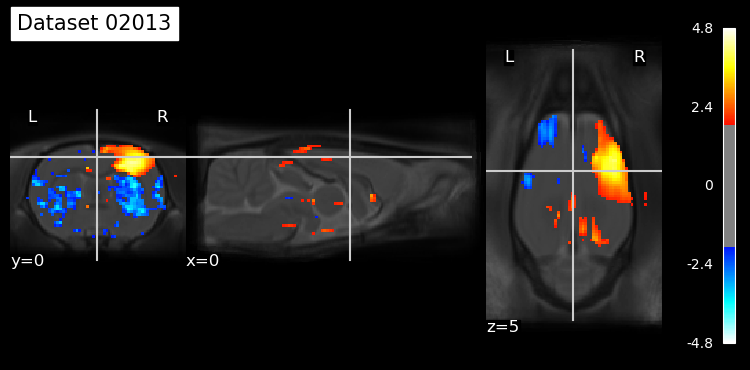

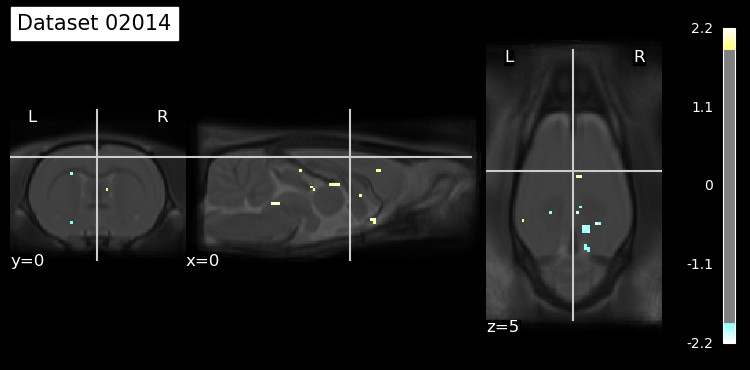

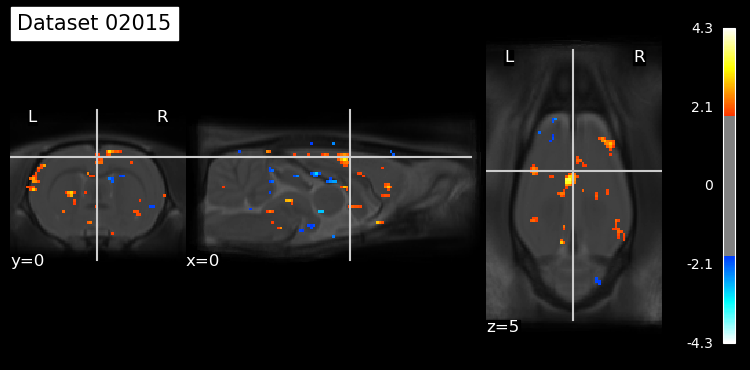

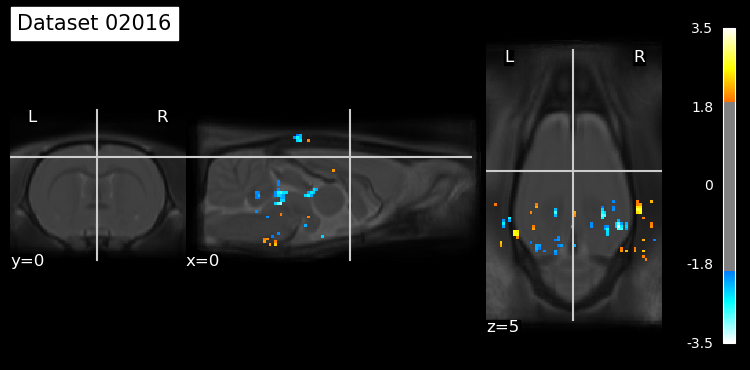

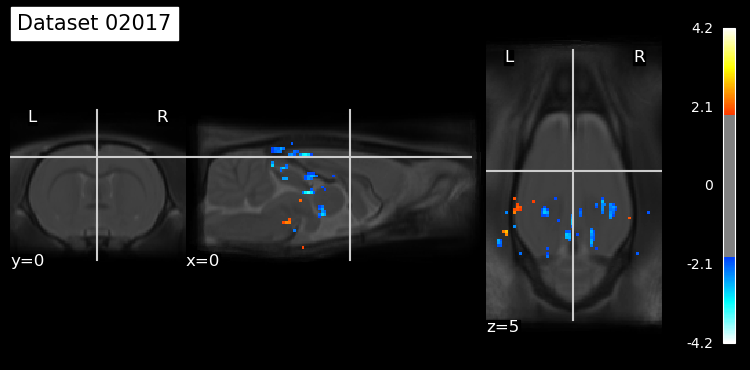

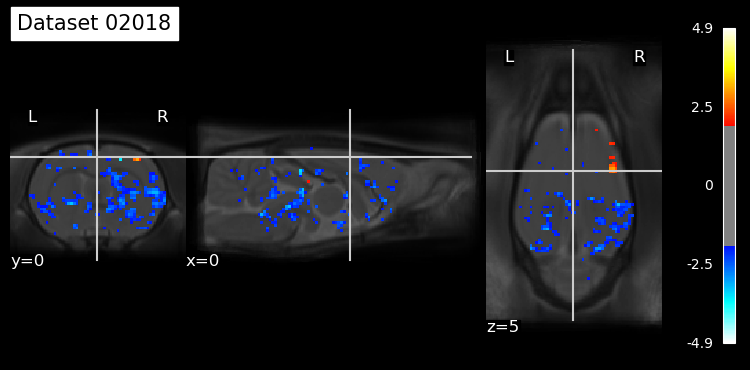

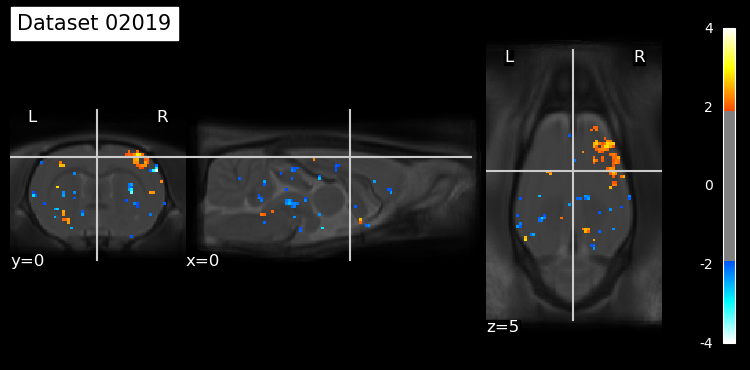

In [8]:
# ---------- SECOND LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

print('First level analysis used:', hrf_function)

for index in range(1, 20):
    
    ID = "0"+str(2000+index)
    print("ID:", ID)
    
    # --- Load data ---
    if hrf_function == 'rat_hrf_gamma_diff':
        dataset = glob.glob(analysis_folder+'rat_hrf_gamma_diff/beta_estimates/beta_sub-{}??_ses-1.nii.gz'.format(ID))
    
    elif hrf_function == 'rat_hrf_delay_disp':
        dataset = glob.glob(analysis_folder+'rat_hrf_delay_disp/beta_estimates/beta_sub-{}??_ses-1.nii.gz'.format(ID))
    
    else:
        print('Check that hrf_function is well defined.')
        
    
    n_subject = len(dataset)                                                           
    print("number of subjects:", n_subject)

    second_level_input = dataset
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])
    
    # --- Specify the model and fit it --- 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                          minimize_memory=False)        #if want to get residuals?

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                        bg_img = template_path,
                                        threshold = 1.9,              
                                        cut_coords= (0 ,0, 5.5),        
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        title="Dataset {}".format(ID))
    
    
    # --- Save output ---  
    plt.savefig(image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 
    nib.save(second_stat_map['z_score'], z_score_dir+'z_score_dataset-{}.nii.gz'.format(ID))          
    nib.save(second_stat_map['effect_size'], beta_dir+'beta_dataset-{}.nii.gz'.format(ID))            
    nib.save(second_stat_map['p_value'], p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))         
